In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

from torch.utils.data import DataLoader
from torchvision import datasets as ds, transforms as tf
from torchvision.utils import make_grid

from collections import OrderedDict

In [2]:
data_root = 'C:/Datasets/Places365/train'
worker = 2
batch_size = 20
image_size = (32, 32)
image_size_out = (256, 256)
nc = 3
nz = 3
ngf = 64
ndf = 64
lr = 1e-3
beta1 = 9e-1
ngpu = 1
weight_decay = 50

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda else 'cpu')
device

device(type='cuda', index=0)

In [4]:
_transforms = {
    "32x32": tf.Compose([
        tf.Resize(image_size[0]),
        tf.CenterCrop(image_size[0]),
        tf.ToTensor()
    ]),
    "256x256": tf.Compose([
        tf.Resize(image_size_out[0]),
        tf.CenterCrop(image_size_out[0]),
        tf.ToTensor()
    ])
}

In [5]:
dataset32 = ds.ImageFolder(root=data_root, transform=_transforms["32x32"])
dataloader32 = DataLoader(dataset32, batch_size=batch_size, shuffle=False, num_workers=worker, pin_memory=is_cuda)

In [6]:
dataset256 = ds.ImageFolder(root=data_root, transform=_transforms["256x256"])
dataloader256 = DataLoader(dataset256, batch_size=batch_size, shuffle=False, num_workers=worker, pin_memory=is_cuda)

Text(0.5, 1.0, '256 x 256 Image Sample')

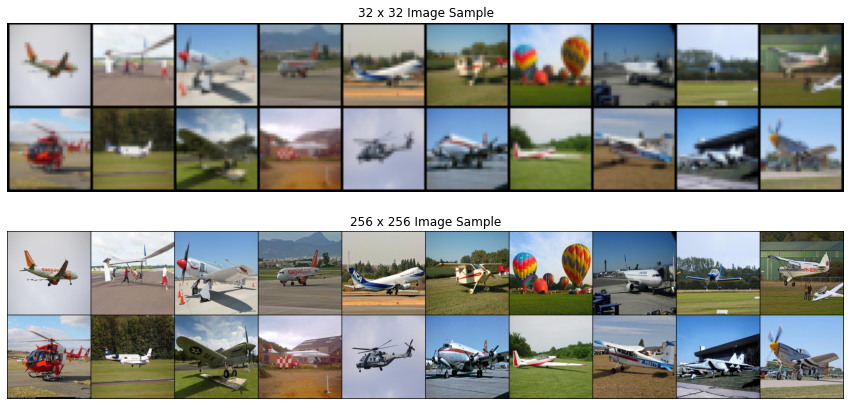

In [7]:
grid32 = next(iter(dataloader32))
grid256 = next(iter(dataloader256))

im32 = make_grid(grid32[0], nrow=10, normalize=True, padding=1)
im256 = make_grid(grid256[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 7))

plt.subplot(211)
plt.imshow(np.transpose(im32, axes=(1, 2, 0)))
plt.axis('off')
plt.title('32 x 32 Image Sample')

plt.subplot(212)
plt.imshow(np.transpose(im256, axes=(1, 2, 0)))
plt.axis('off')
plt.title('256 x 256 Image Sample')

## Super Sampling Model Development.

In [8]:
class SuperSamplingModel(nn.Module):

    def __init__(self, in_channels=nz, out_channels=nc):
        super(SuperSamplingModel, self).__init__()

        self.main = nn.Sequential(OrderedDict([
            (
                'conv1', nn.Sequential(
                    nn.ConvTranspose2d(in_channels=in_channels, out_channels=3, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU()
                )
            ),(
                'conv2', nn.Sequential(
                    nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU()
                )
            ),(
                'conv3', nn.Sequential(
                    nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU()
                )
            ),(
                'conv4', nn.Sequential(
                    nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=1, stride=1),
                    nn.ReLU()
                )
            )
        ]))

    def forward(self, X):
        return self.main(X)

netDLSS = SuperSamplingModel().to(device)
netDLSS

SuperSamplingModel(
  (main): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): ConvTranspose2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
  )
)

In [9]:
with torch.no_grad():

    x = torch.ones(10, 3, 32, 32, device=device)
    out = netDLSS(x)

    print(out.shape)

torch.Size([10, 3, 256, 256])


In [10]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(netDLSS.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
windowName = "TRAINING VISUALIZATION"
cv2.namedWindow(windowName, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(windowName, 1280, 256)

epochs = 5
batch_limit = 10000
print_limit = 500
is_broke = False

losses = []

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(dataloader32, dataloader256)):
        batch += 1

        optimizer.zero_grad()

        X = X[0].to(device)
        y = y[0].to(device)

        out = netDLSS(X)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        if batch == 1 or batch % print_limit == 0:
            print(f'Epoch: {i}/{epochs}, Batch: {batch}/{batch_limit} -> Loss: {loss:.9f}')
            losses.append(loss)

        if batch == 1  or batch % 100 == 0:
            grid = make_grid(out.detach().cpu(), nrow=10, normalize=True)
            grid = np.transpose(grid.numpy(), axes=(1, 2, 0))
            grid = cv2.cvtColor(grid, code=cv2.COLOR_RGB2BGR)

            cv2.imshow(windowName, grid)

        if cv2.waitKey(1) & 0xFFF == 27:
            is_broke = True
            break

        if batch_limit == batch:
            break

    if is_broke:
        cv2.destroyAllWindows()
        break

duration = time.time() - start
print(f'Execution Time -> {duration / 60:.4f} minutes')

Epoch: 1/5, Batch: 1/10000 -> Loss: 0.270835012
Epoch: 1/5, Batch: 500/10000 -> Loss: 0.016462246
Epoch: 1/5, Batch: 1000/10000 -> Loss: 0.012840236
Epoch: 1/5, Batch: 1500/10000 -> Loss: 0.017725674
Epoch: 1/5, Batch: 2000/10000 -> Loss: 0.020421864
Epoch: 1/5, Batch: 2500/10000 -> Loss: 0.016502690
Epoch: 1/5, Batch: 3000/10000 -> Loss: 0.016307944
Epoch: 1/5, Batch: 3500/10000 -> Loss: 0.008977038
Epoch: 1/5, Batch: 4000/10000 -> Loss: 0.015042515
Epoch: 1/5, Batch: 4500/10000 -> Loss: 0.012084727
Epoch: 1/5, Batch: 5000/10000 -> Loss: 0.011631601
Epoch: 1/5, Batch: 5500/10000 -> Loss: 0.013874623
Epoch: 1/5, Batch: 6000/10000 -> Loss: 0.012755802
Epoch: 1/5, Batch: 6500/10000 -> Loss: 0.005543216
Epoch: 1/5, Batch: 7000/10000 -> Loss: 0.016487777
Epoch: 1/5, Batch: 7500/10000 -> Loss: 0.006058873
Epoch: 1/5, Batch: 8000/10000 -> Loss: 0.013654829
Epoch: 1/5, Batch: 8500/10000 -> Loss: 0.019927863
Epoch: 1/5, Batch: 9000/10000 -> Loss: 0.015083689
Epoch: 1/5, Batch: 9500/10000 -> Lo

In [12]:
cv2.destroyAllWindows()